##BankTermPredict: Predicting Client Subscription to Term Deposits from Campaign Data

Exploratory Data Analysis  
Source:  https://archive.ics.uci.edu/dataset/222/bank+marketing  
Greg Gibson Sept. 2025

This notebook will perform the following EDA tasks:
- Load the dataset and explore its structure
- Handle missing values, duplicates, and data types
- Analyze distributions of key features (age, balance, campaign, etc.)
- Check for target class imbalance (`y` variable)
- Summarize insights with visualizations (histograms, boxplots, correlation heatmaps)


Findings:

- Target column is y, representing whether customer subscribed to a term deposit
    - Target column is unbalanced, being under 12% positive
- 16 features, 45k entries
- 3 binary, 5 categorical, 6 integers plus day number of the month and three-letter month abbreviation
    - day_of_week is a misnomer -> changed to day_of_month, convert into a cyclical feature
- No duplicate rows
- Missing values in job, education, contact and poutcome
    - All have a value = 'unknown', which was applied to all missing values
- Heavy skewing of balance and campaign, age is closer to normally distributed
- Pdays and Previous columns have moderate correlation (days since prior contact from previous campaign, number of contacts to client performed in prior campaign) 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

In [33]:
# fetch dataset (code per website instructions)
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

In [6]:
# Explore dataset structure
print('Features shape:', X.shape)
print('Targets shape:', y.shape)
print('\nFirst 5 rows of features:')
display(X.head())
print('\nFirst 5 rows of targets:')
display(y.head())
print('\nFeatures info:')
X.info()
print('\nTargets info:')
y.info()
print('\nFeatures description:')
display(X.describe(include='all'))

Features shape: (45211, 16)
Targets shape: (45211, 1)

First 5 rows of features:


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN



First 5 rows of targets:


,y
0,no
1,no
2,no
3,no
4,no



Features info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB

Targets info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
count,45211.000000,44923,45211,43354,45211,45211.000000,45211,45211,32191,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,8252
unique,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,failure
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,4901
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN


In [34]:
# Rename day_of_week
X = X.rename(columns={'day_of_week': 'day_of_month'})

In [7]:
# Handle missing values, duplicates, and check data types
print('Missing values in features:')
display(X.isnull().sum())
print('Missing values in targets:')
display(y.isnull().sum())

print('Number of duplicate rows in features:', X.duplicated().sum())
print('Number of duplicate rows in targets:', y.duplicated().sum())

print('Feature data types:')
print(X.dtypes)
print('\nTarget data types:')
print(y.dtypes)

Missing values in features:


age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

Missing values in targets:


y    0
dtype: int64

Number of duplicate rows in features: 0
Number of duplicate rows in targets: 45209
Feature data types:
age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
dtype: object

Target data types:
y    object
dtype: object


In [16]:
# Update missing values to existing category 'unknown'
cols_with_unknown = ['job', 'education', 'contact', 'poutcome']
for col in cols_with_unknown:
    if col in X.columns:
        X[col] = X[col].replace(np.nan, 'unknown')

print('Updated missing values in job, education, contact, poutcome.')
display(X[cols_with_unknown].isnull().sum())

Updated missing values in job, education, contact, poutcome.


C:\Users\ggibs\AppData\Local\Temp\ipykernel_7120\4059869806.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].replace(np.nan, 'unknown')


job          0
education    0
contact      0
poutcome     0
dtype: int64

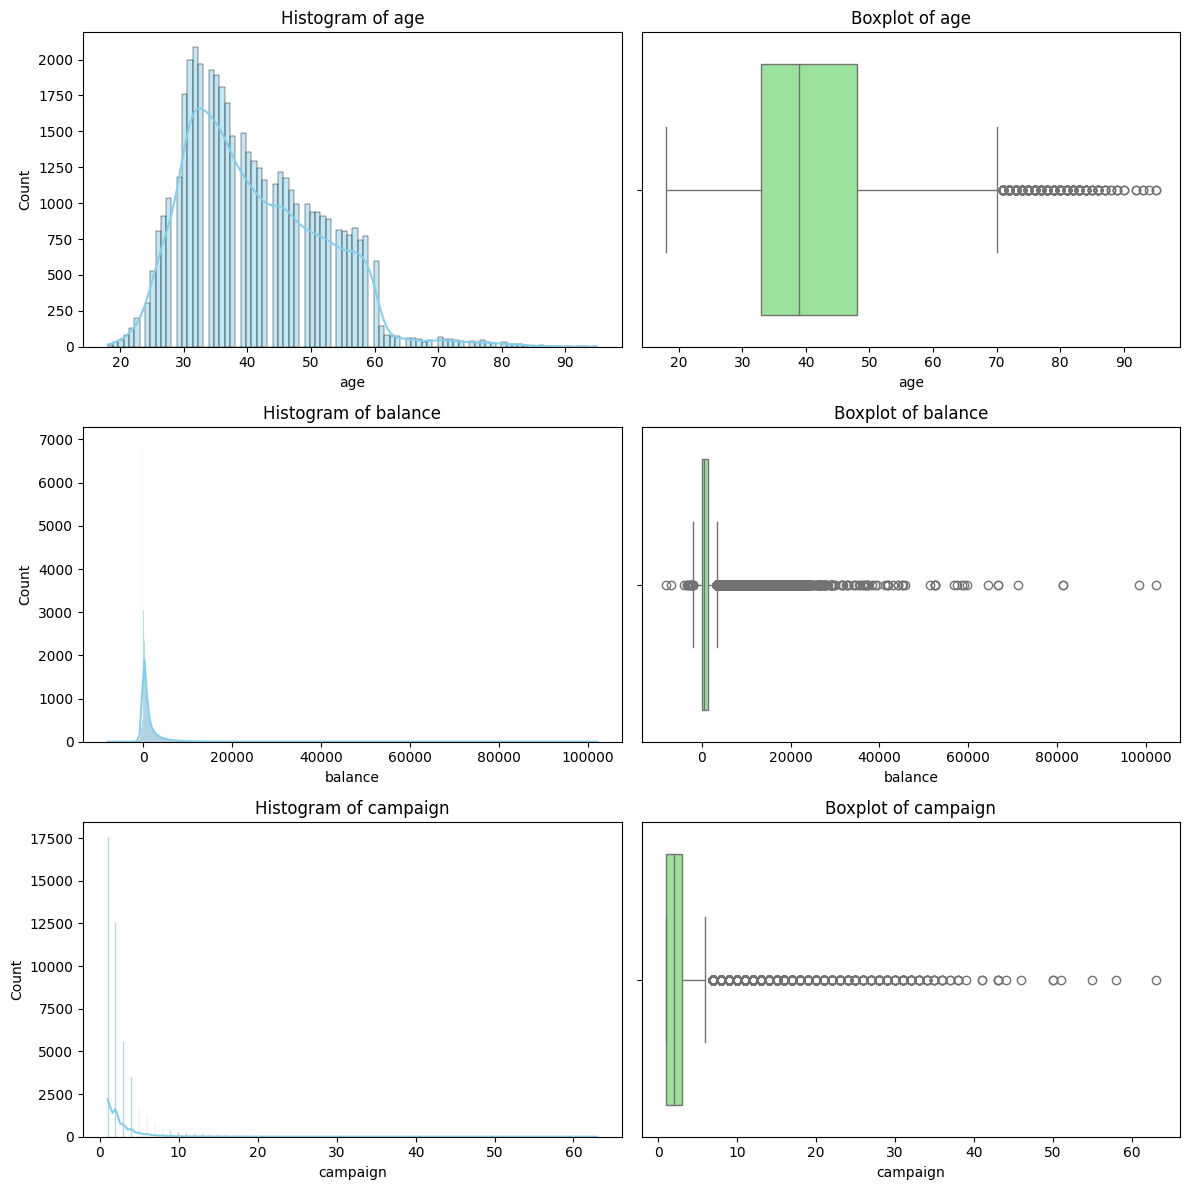

In [8]:
# Analyze distributions of key features
key_features = ['age', 'balance', 'campaign']
fig, axes = plt.subplots(len(key_features), 2, figsize=(12, 12))
for i, feature in enumerate(key_features):
    sns.histplot(X[feature], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Histogram of {feature}')
    sns.boxplot(x=X[feature], ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

Target class distribution:
y
no     39922
yes     5289
Name: count, dtype: int64


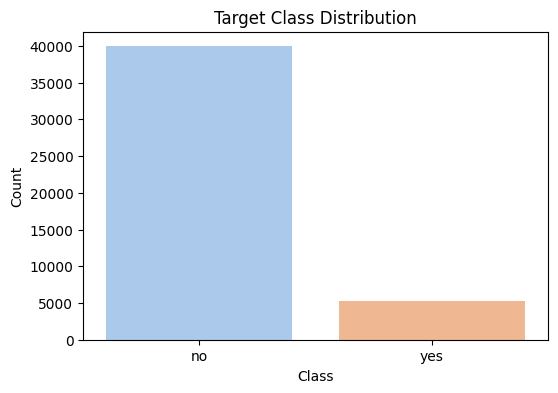

In [13]:
# Check for target class imbalance
target_col = y.columns[0] if hasattr(y, 'columns') else y.name
class_counts = y[target_col].value_counts()
print('Target class distribution:')
print(class_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='pastel', hue=class_counts.index, legend=False)
plt.title('Target Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

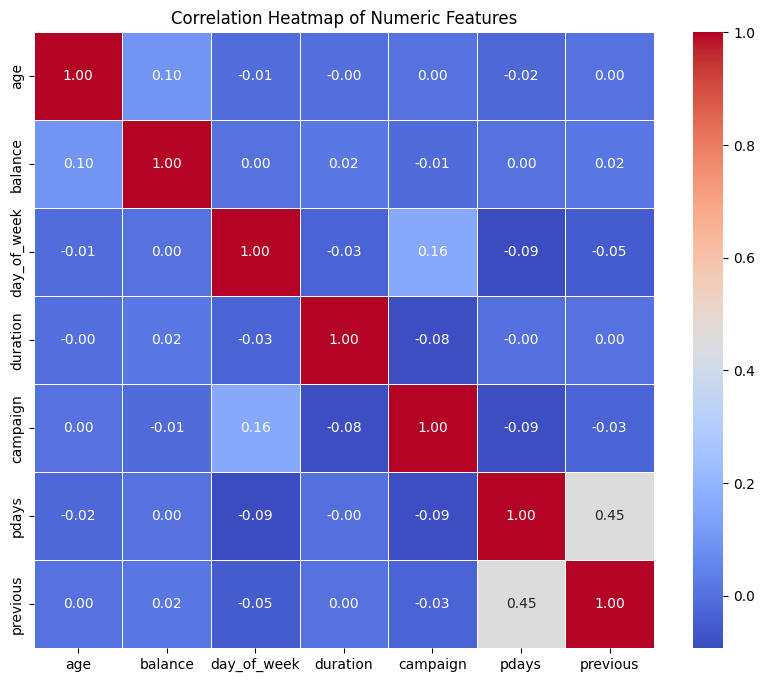

In [15]:
# Correlation heatmap for numeric features
plt.figure(figsize=(10,8))
corr = X.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()
